### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Diable warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV


from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.linear_model import LinearRegression, PoissonRegressor, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_log_error, make_scorer

sns.set_theme(style='darkgrid',font_scale=1.3)

### Load Data

In [2]:
df = pd.read_csv('../data/train.csv',index_col=0, parse_dates=True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [4]:
# check missing values
df.isna().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

### Data Preprocessing

#### Extract time features

In [5]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,weekday,hour
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,5,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,5,4


### Exploratory Data Analysis

#### Correlation Analysis of Features

<AxesSubplot:>

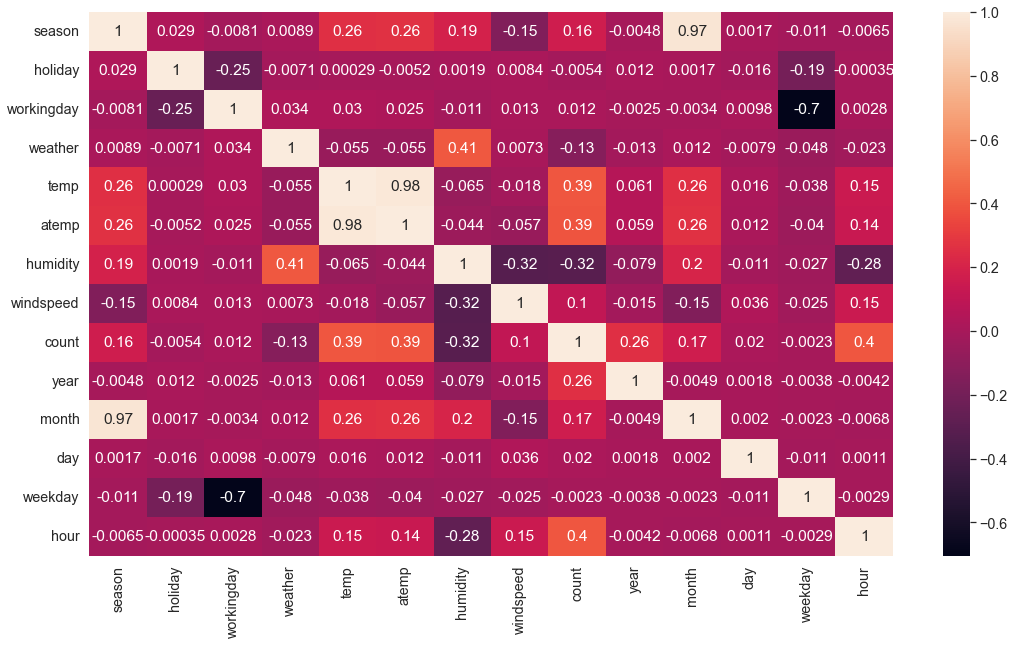

In [6]:
df.head()
plt.figure(figsize=(18,10))
corr = df.drop(['casual','registered'],axis=1).corr()
sns.heatmap(corr, annot=True)

There is high correlation between ```month``` and ```season```, ```weekday``` and ```workingday```, ```temp``` and ```atemp```

Therefore we can drop ``` workingday```, ```season``` and ```atemp```  

In [7]:
# Drop 'workingday', 'season', and 'atemp' 
df.drop(['workingday', 'season', 'atemp'], axis = 1, inplace = True)

#### Analyze Average of Counts Per Time 

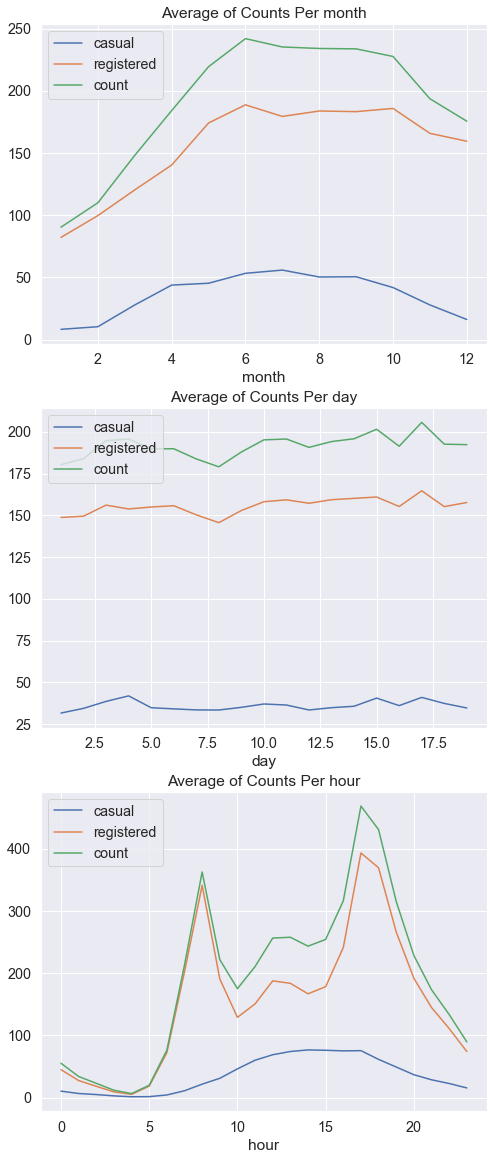

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(8, 20))
ax = ax.flatten() 
features = ['month','day','hour']

for index,feature in enumerate(features):
        
        sns.lineplot(ax=ax[index],x=feature,y='casual',data=df.groupby(feature)['casual'].mean().reset_index(),label ='casual')
        sns.lineplot(ax=ax[index],x=feature,y='registered',data=df.groupby(feature)['registered'].mean().reset_index(),label= 'registered')
        sns.lineplot(ax=ax[index],x=feature,y='count',data=df.groupby(feature)['count'].mean().reset_index(),label = 'count')
        ax[index].legend(loc='upper left')
        ax[index].set_ylabel('')
        ax[index].set_title(f'Average of Counts Per {feature}')

#### Analyze Hourly Trends

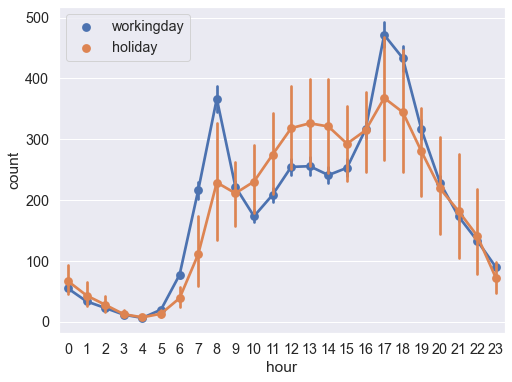

In [9]:
# Hourly trends of count of bikes during weekdays and holdays
fig = plt.figure(figsize=(8,6))
ax = sns.pointplot(data=df, x='hour', y='count', hue='holiday');
handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles,['workingday','holiday']);

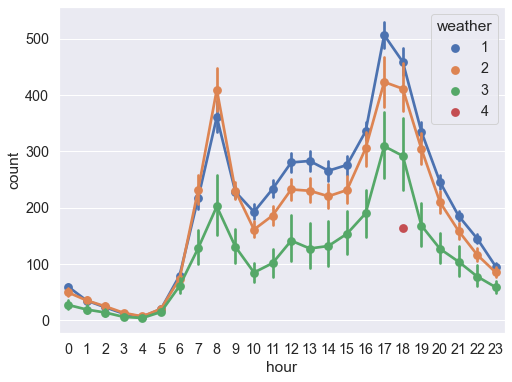

In [10]:
# Hourly trends of count of bikes with differet weather condition (1 = good -> 4 = very bad)
fig = plt.figure(figsize=(8,6))
sns.pointplot(data=df, x="hour", y="count", hue="weather");

#### Analyze Affect of Selected Features on Count

##### Environmental Conditions

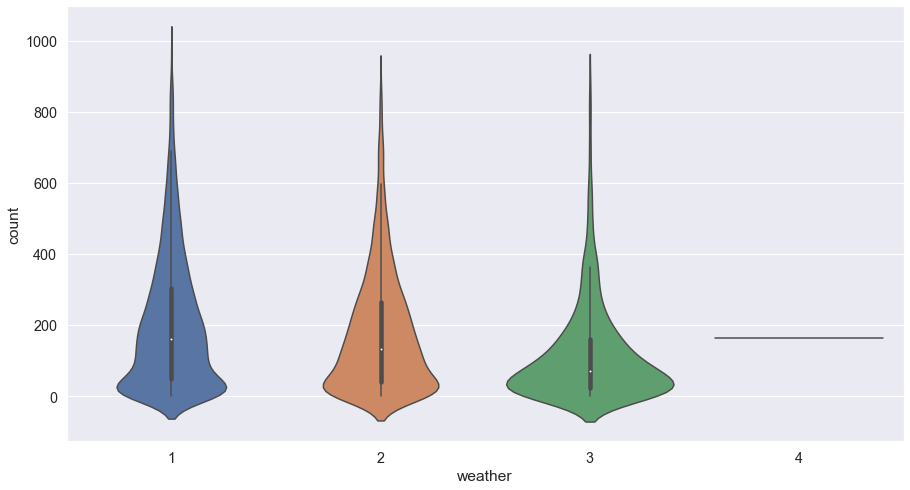

In [11]:
# Counts depending on weather
plt.figure(figsize=(15,8))
ax = sns.violinplot(x=df['weather'].astype(str),y=df['count'], size = 4)
plt.show()

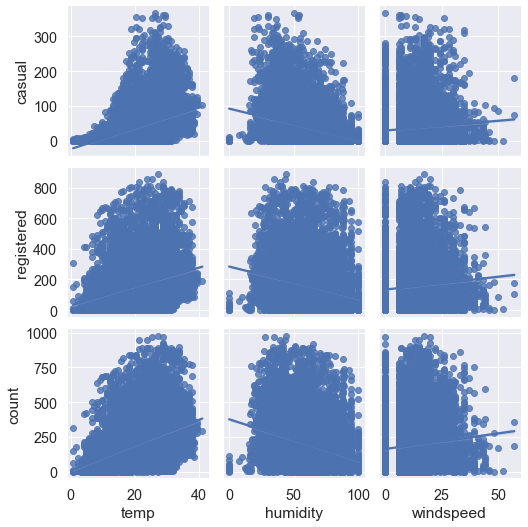

In [12]:
# Counts depending on temp, humidity and, windspeed
sns.pairplot(data = df,
             x_vars = ['temp', 'humidity', 'windspeed'],
             y_vars = ['casual', 'registered', 'count'],
             kind='reg')

People prefer more cycling as the days get hotter and prefere less cycling as the days get wetter

##### Other Features

<AxesSubplot:xlabel='holiday', ylabel='count'>

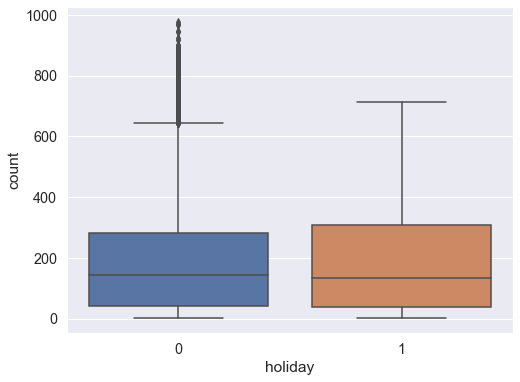

In [13]:
# Counts depending on holiday (holiday = 1)
plt.figure(figsize=(8,6))
sns.boxplot(data = df, x='holiday', y='count')

### Define Global Fucntions

In [14]:

def rmsle(y_true, y_pred):
    """The rmsle function for evaluation"""
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [15]:
# Transform rmsle fucntion into scorer 
rmsle_scorer = make_scorer(score_func=rmsle, greater_is_better=False)

In [16]:
def print_evaluation_metrics(model,X_train,y_train,X_test,y_test):
    """ Print out R2 and RMSLE as evaluation metrics """
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print(f'R2 train : {round(model.score(X_train,y_train),2)}')
    print(f'R2 test: {round(model.score(X_test,y_test),2)}')
    print('\n')
    print(f'RMSLE train: {round(rmsle(y_train, y_pred_train),2)}')
    print(f'RMSLE test: {round(rmsle(y_test, y_pred_test),2)}')

In [17]:
def print_results(cv_h, show_all = False):
    """Print out results of the hyperparameter optimization"""
    print('Best:')
    print(round(cv_h.best_score_, 3), ' for ', cv_h.best_params_)
    if show_all:
        print('All:')
        for mean, params in zip(cv_h.cv_results_['mean_test_score'], 
                                cv_h.cv_results_['params']):
                print('{}  for {}'.format(round(mean, 3), params))

### Linear Regression

In [18]:
# define features and target
X = df.drop(['count','registered','casual'], axis=1)
y = df['count']

In [19]:
# Train-test split of the data
X_train,X_test,y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=100)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 10), (2178, 10), (8708,), (2178,))

#### Feature Engineering

Numeric columns should be scaled, categorical columns should be onehot encoded, use of polynomial features

##### Define Pipelines

In [20]:
# Scaling for numeric variables
num_pipe = make_pipeline(
    MinMaxScaler()
)

In [21]:
# One_hot_encoding for categorical variables
cat_pipe = make_pipeline(
    OneHotEncoder(handle_unknown = 'ignore')
)

In [22]:
# Define preprocessor
feature_transform = ColumnTransformer([
    ('do_nothing', 'passthrough', ['holiday']), 
    ('one_hot_encoding', cat_pipe, ['weather','year', 'month', 'day', 'hour']),
    ('scaling', num_pipe, ['temp','humidity', 'windspeed'])
])

#### Create Model

In [23]:
lr = Pipeline([
            ('preprocessor', feature_transform),
            ('poly_features', PolynomialFeatures(degree=2, 
                                                 include_bias=False, 
                                                 interaction_only=False)),
            ('m_lr', LinearRegression())
])

# Do target transformation
lr_t = TransformedTargetRegressor(regressor=lr, func=np.log1p, inverse_func=np.expm1)

In [24]:
lr_t.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('do_nothing',
                                                                                       'passthrough',
                                                                                       ['holiday']),
                                                                                      ('one_hot_encoding',
                                                                                       Pipeline(steps=[('onehotencoder',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['weather',
                                                                                        'year',
                                                                                        'month',
                                                                                        'day',
                                                                                        'hour']),
                                                                                      ('scaling',
                                                                                       Pipeline(steps=[('minmaxscaler',
                                                                                                        MinMaxScaler())]),
                                                                                       ['temp',
                                                                                        'humidity',
                                                                                        'windspeed'])])),
                                                     ('poly_features',
                                                      PolynomialFeatures(include_bias=False)),
                                                     ('m_lr',
                                                      LinearRegression())]))

#### Evaluate Model

In [25]:
print_evaluation_metrics(lr_t,X_train,y_train,X_test,y_test)

R2 train : 0.79
R2 test: 0.72


RMSLE train: 0.52
RMSLE test: 0.63


In [26]:
# # save evaluation metrics using cross validation
# def save_evaluation_metrics(model,model_name, summary, X, y):
    
#     R2 = round(cross_val_score(model, X, y, cv = 4, scoring='r2').mean(),2)
#     RMSLE = round(cross_val_score(model, X, y, cv = 4, scoring=rmsle_scorer).mean(),2)
    
    
#     summary['Model Name'].append(model_name)
#     summary['R2'].append(R2)
    
    
#     return summary

In [27]:
# summary = {'Model Name':[],'R2':[],'RMSLE':[]}

# summary = save_evaluation_metrics(lr_t,'Linear Regressin',summary,X,y)
# summary

### Ridge Regression

#### Feature Engineering

Same as linear regression

#### Create Model

In [28]:
rr = Pipeline([
    ('preprocessor', feature_transform),
    ('poly_features', PolynomialFeatures(degree=2, 
                                         include_bias=False,
                                         interaction_only=False)),
    ('m_rr', Ridge(alpha=1))
])
# Do target transformation
rr_t = TransformedTargetRegressor(regressor=rr, func=np.log1p, inverse_func=np.expm1)

In [29]:
rr_t.fit(X_train,y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('do_nothing',
                                                                                       'passthrough',
                                                                                       ['holiday']),
                                                                                      ('one_hot_encoding',
                                                                                       Pipeline(steps=[('onehotencoder',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['weather',
                                                                                        'year',
                                                                                        'month',
                                                                                        'day',
                                                                                        'hour']),
                                                                                      ('scaling',
                                                                                       Pipeline(steps=[('minmaxscaler',
                                                                                                        MinMaxScaler())]),
                                                                                       ['temp',
                                                                                        'humidity',
                                                                                        'windspeed'])])),
                                                     ('poly_features',
                                                      PolynomialFeatures(include_bias=False)),
                                                     ('m_rr', Ridge(alpha=1))]))

#### Tune Hyperparameters

In [30]:
# get list of hyperparameters
rr_t.get_params().keys()

dict_keys(['check_inverse', 'func', 'inverse_func', 'regressor__memory', 'regressor__steps', 'regressor__verbose', 'regressor__preprocessor', 'regressor__poly_features', 'regressor__m_rr', 'regressor__preprocessor__n_jobs', 'regressor__preprocessor__remainder', 'regressor__preprocessor__sparse_threshold', 'regressor__preprocessor__transformer_weights', 'regressor__preprocessor__transformers', 'regressor__preprocessor__verbose', 'regressor__preprocessor__verbose_feature_names_out', 'regressor__preprocessor__do_nothing', 'regressor__preprocessor__one_hot_encoding', 'regressor__preprocessor__scaling', 'regressor__preprocessor__one_hot_encoding__memory', 'regressor__preprocessor__one_hot_encoding__steps', 'regressor__preprocessor__one_hot_encoding__verbose', 'regressor__preprocessor__one_hot_encoding__onehotencoder', 'regressor__preprocessor__one_hot_encoding__onehotencoder__categories', 'regressor__preprocessor__one_hot_encoding__onehotencoder__drop', 'regressor__preprocessor__one_hot_enc

In [31]:
parameters = {'regressor__m_rr__alpha': np.arange(1e-2,50,0.5)}

In [32]:
cv_h =  GridSearchCV(estimator=rr_t,param_grid=parameters,cv=5,n_jobs=-1)

In [33]:
cv_h.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('do_nothing',
                                                                                                              'passthrough',
                                                                                                              ['holiday']),
                                                                                                             ('one_hot_encoding',
                                                                                                              Pipeline(steps=[('onehotencoder',
                                                                                                                               OneHotEncoder(handle_unknown='ignore'))]),
                                                                                                              ['weather',
                                                                                                               'year',
                                                                                                               'month',
                                                                                                               'day',
                                                                                                               'hour...
       3.001e+01, 3.051e+01, 3.101e+01, 3.151e+01, 3.201e+01, 3.251e+01,
       3.301e+01, 3.351e+01, 3.401e+01, 3.451e+01, 3.501e+01, 3.551e+01,
       3.601e+01, 3.651e+01, 3.701e+01, 3.751e+01, 3.801e+01, 3.851e+01,
       3.901e+01, 3.951e+01, 4.001e+01, 4.051e+01, 4.101e+01, 4.151e+01,
       4.201e+01, 4.251e+01, 4.301e+01, 4.351e+01, 4.401e+01, 4.451e+01,
       4.501e+01, 4.551e+01, 4.601e+01, 4.651e+01, 4.701e+01, 4.751e+01,
       4.801e+01, 4.851e+01, 4.901e+01, 4.951e+01])})

In [34]:
# Print results of hyperparameter optimization using random search       
print_results(cv_h, show_all=False)

Best:
0.739  for  {'regressor__m_rr__alpha': 34.01}


In [35]:
# Extract best model
rr_t_best = cv_h.best_estimator_
rr_t_best

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('do_nothing',
                                                                                       'passthrough',
                                                                                       ['holiday']),
                                                                                      ('one_hot_encoding',
                                                                                       Pipeline(steps=[('onehotencoder',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['weather',
                                                                                        'year',
                                                                                        'month',
                                                                                        'day',
                                                                                        'hour']),
                                                                                      ('scaling',
                                                                                       Pipeline(steps=[('minmaxscaler',
                                                                                                        MinMaxScaler())]),
                                                                                       ['temp',
                                                                                        'humidity',
                                                                                        'windspeed'])])),
                                                     ('poly_features',
                                                      PolynomialFeatures(include_bias=False)),
                                                     ('m_rr',
                                                      Ridge(alpha=34.01))]))

#### Evaluate Model

In [36]:
print_evaluation_metrics(rr_t_best,X_train,y_train,X_test,y_test)

R2 train : 0.77
R2 test: 0.74


RMSLE train: 0.54
RMSLE test: 0.6


### Lasso Regression

#### Featrure Engineering

same as linear regression

#### Create Model

In [37]:
lar = Pipeline([
    ('preprocessor', feature_transform),
    ('poly_features', PolynomialFeatures(degree=2, 
                                        include_bias=False,
                                        interaction_only=False)),
    ('m_lar', Lasso(alpha=0.001,max_iter=10000))
])
# Do target transformation
lar_t = TransformedTargetRegressor(regressor=lar, func=np.log1p, inverse_func=np.expm1)

In [38]:
lar_t.fit(X_train,y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('do_nothing',
                                                                                       'passthrough',
                                                                                       ['holiday']),
                                                                                      ('one_hot_encoding',
                                                                                       Pipeline(steps=[('onehotencoder',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['weather',
                                                                                        'year',
                                                                                        'month',
                                                                                        'day',
                                                                                        'hour']),
                                                                                      ('scaling',
                                                                                       Pipeline(steps=[('minmaxscaler',
                                                                                                        MinMaxScaler())]),
                                                                                       ['temp',
                                                                                        'humidity',
                                                                                        'windspeed'])])),
                                                     ('poly_features',
                                                      PolynomialFeatures(include_bias=False)),
                                                     ('m_lar',
                                                      Lasso(alpha=0.001,
                                                            max_iter=10000))]))

#### Tune Hyperparameters

In [39]:
# get list of hyperparameters
lar_t.get_params().keys()

dict_keys(['check_inverse', 'func', 'inverse_func', 'regressor__memory', 'regressor__steps', 'regressor__verbose', 'regressor__preprocessor', 'regressor__poly_features', 'regressor__m_lar', 'regressor__preprocessor__n_jobs', 'regressor__preprocessor__remainder', 'regressor__preprocessor__sparse_threshold', 'regressor__preprocessor__transformer_weights', 'regressor__preprocessor__transformers', 'regressor__preprocessor__verbose', 'regressor__preprocessor__verbose_feature_names_out', 'regressor__preprocessor__do_nothing', 'regressor__preprocessor__one_hot_encoding', 'regressor__preprocessor__scaling', 'regressor__preprocessor__one_hot_encoding__memory', 'regressor__preprocessor__one_hot_encoding__steps', 'regressor__preprocessor__one_hot_encoding__verbose', 'regressor__preprocessor__one_hot_encoding__onehotencoder', 'regressor__preprocessor__one_hot_encoding__onehotencoder__categories', 'regressor__preprocessor__one_hot_encoding__onehotencoder__drop', 'regressor__preprocessor__one_hot_en

In [40]:
parameters = {'regressor__m_lar__alpha': np.arange(1e-4,5e-3,1e-5)}

In [41]:
cv_h =  GridSearchCV(estimator=lar_t,param_grid=parameters,cv=5,n_jobs=-1)

In [42]:
cv_h.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('do_nothing',
                                                                                                              'passthrough',
                                                                                                              ['holiday']),
                                                                                                             ('one_hot_encoding',
                                                                                                              Pipeline(steps=[('onehotencoder',
                                                                                                                               OneHotEncoder(handle_unknown='ignore'))]),
                                                                                                              ['weather',
                                                                                                               'year',
                                                                                                               'month',
                                                                                                               'day',
                                                                                                               'hour...
       0.00451, 0.00452, 0.00453, 0.00454, 0.00455, 0.00456, 0.00457,
       0.00458, 0.00459, 0.0046 , 0.00461, 0.00462, 0.00463, 0.00464,
       0.00465, 0.00466, 0.00467, 0.00468, 0.00469, 0.0047 , 0.00471,
       0.00472, 0.00473, 0.00474, 0.00475, 0.00476, 0.00477, 0.00478,
       0.00479, 0.0048 , 0.00481, 0.00482, 0.00483, 0.00484, 0.00485,
       0.00486, 0.00487, 0.00488, 0.00489, 0.0049 , 0.00491, 0.00492,
       0.00493, 0.00494, 0.00495, 0.00496, 0.00497, 0.00498, 0.00499])})

In [43]:
# Print results of hyperparameter optimization using random search       
print_results(cv_h, show_all=False)

Best:
0.752  for  {'regressor__m_lar__alpha': 0.00047999999999999996}


In [44]:
# Extract best model
lar_t_best = cv_h.best_estimator_
lar_t_best

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('do_nothing',
                                                                                       'passthrough',
                                                                                       ['holiday']),
                                                                                      ('one_hot_encoding',
                                                                                       Pipeline(steps=[('onehotencoder',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['weather',
                                                                                        'year',
                                                                                        'month',
                                                                                        'day',
                                                                                        'hour']),
                                                                                      ('scaling',
                                                                                       Pipeline(steps=[('minmaxscaler',
                                                                                                        MinMaxScaler())]),
                                                                                       ['temp',
                                                                                        'humidity',
                                                                                        'windspeed'])])),
                                                     ('poly_features',
                                                      PolynomialFeatures(include_bias=False)),
                                                     ('m_lar',
                                                      Lasso(alpha=0.00047999999999999996,
                                                            max_iter=10000))]))

#### Evaluate Model

In [45]:
print_evaluation_metrics(lar_t_best,X_train,y_train,X_test,y_test)

R2 train : 0.77
R2 test: 0.75


RMSLE train: 0.55
RMSLE test: 0.59


### Poisson Regression

#### Feature Engineering

Same as linear regression

#### Create Model

In [46]:
pr = Pipeline([
    ('preprocessor', feature_transform),
    ('poly_features', PolynomialFeatures(degree=2, 
                                         include_bias=False,
                                         interaction_only=False)),
    ('m_pr', PoissonRegressor(alpha=0,max_iter=10000))
])

In [47]:
pr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('do_nothing', 'passthrough',
                                                  ['holiday']),
                                                 ('one_hot_encoding',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['weather', 'year', 'month',
                                                   'day', 'hour']),
                                                 ('scaling',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['temp', 'humidity',
                                                   'windspeed'])])),
                ('poly_features', PolynomialFeatures(include_bias=False)),
                ('m_pr', PoissonRegressor(alpha=0, max_iter=10000))])

#### Tune Hyperparameters

In [48]:
# get list of hyperparameters
pr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'poly_features', 'm_pr', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__do_nothing', 'preprocessor__one_hot_encoding', 'preprocessor__scaling', 'preprocessor__one_hot_encoding__memory', 'preprocessor__one_hot_encoding__steps', 'preprocessor__one_hot_encoding__verbose', 'preprocessor__one_hot_encoding__onehotencoder', 'preprocessor__one_hot_encoding__onehotencoder__categories', 'preprocessor__one_hot_encoding__onehotencoder__drop', 'preprocessor__one_hot_encoding__onehotencoder__dtype', 'preprocessor__one_hot_encoding__onehotencoder__handle_unknown', 'preprocessor__one_hot_encoding__onehotencoder__max_categories', 'preprocessor__one_hot_encoding__onehotencoder__min_frequency', 'preprocessor__one_hot_encoding__onehotencoder__sparse', 'preprocessor

In [49]:
parameters = {'m_pr__alpha': np.arange(0,10,0.1)}

In [50]:
cv_h =  GridSearchCV(estimator=pr,param_grid=parameters,cv=5,n_jobs=-1)

In [51]:
cv_h.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('do_nothing',
                                                                         'passthrough',
                                                                         ['holiday']),
                                                                        ('one_hot_encoding',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['weather',
                                                                          'year',
                                                                          'month',
                                                                          'day',
                                                                          'hour']),
                                                                        ('scaling',
                                                                         Pipeline(steps=[('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['temp',
                                                                          'humidity',
                                                                          '...
             param_grid={'m_pr__alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
       7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ,
       9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])})

In [52]:
# Print results of hyperparameter optimization using random search       
print_results(cv_h, show_all=False)

Best:
0.808  for  {'m_pr__alpha': 0.6000000000000001}


In [53]:
# Extract best model
pr_best = cv_h.best_estimator_
pr_best

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('do_nothing', 'passthrough',
                                                  ['holiday']),
                                                 ('one_hot_encoding',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['weather', 'year', 'month',
                                                   'day', 'hour']),
                                                 ('scaling',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['temp', 'humidity',
                                                   'windspeed'])])),
                ('poly_features', PolynomialFeatures(include_bias=False)),
                ('m_pr',
                 PoissonRegressor(alpha=0.6000000000000001, max_iter=10000))])

#### Evaluate Model

In [54]:
print_evaluation_metrics(pr_best,X_train,y_train,X_test,y_test)

R2 train : 0.84
R2 test: 0.8


RMSLE train: 0.64
RMSLE test: 0.69


### Random Forest Regression

#### Feature Engineering

Not required

#### Create Model

In [55]:
rfr_t = TransformedTargetRegressor(regressor=RandomForestRegressor(),func=np.log1p, inverse_func=np.expm1)

In [56]:
rfr_t.fit(X_train,y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=RandomForestRegressor())

#### Tune Hyperparameters

In [57]:
rfr_t.get_params().keys()

dict_keys(['check_inverse', 'func', 'inverse_func', 'regressor__bootstrap', 'regressor__ccp_alpha', 'regressor__criterion', 'regressor__max_depth', 'regressor__max_features', 'regressor__max_leaf_nodes', 'regressor__max_samples', 'regressor__min_impurity_decrease', 'regressor__min_samples_leaf', 'regressor__min_samples_split', 'regressor__min_weight_fraction_leaf', 'regressor__n_estimators', 'regressor__n_jobs', 'regressor__oob_score', 'regressor__random_state', 'regressor__verbose', 'regressor__warm_start', 'regressor', 'transformer'])

In [58]:
parameters = {'regressor__n_estimators' : [50, 100, 200, 300, 400],
             'regressor__max_depth' : [5, 50, 100]
             }

In [59]:
cv_h =  GridSearchCV(estimator=rfr_t,param_grid=parameters,cv=5,n_jobs=-1)

In [60]:
cv_h.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=RandomForestRegressor()),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [5, 50, 100],
                         'regressor__n_estimators': [50, 100, 200, 300, 400]})

In [61]:
# Print results of hyperparameter optimization using random search       
print_results(cv_h, show_all=False)

Best:
0.941  for  {'regressor__max_depth': 100, 'regressor__n_estimators': 400}


In [62]:
# Extract best model
rfr_t_best = cv_h.best_estimator_
rfr_t_best

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=RandomForestRegressor(max_depth=100,
                                                           n_estimators=400))

#### Evaluate Model

In [63]:
print_evaluation_metrics(rfr_t_best,X_train,y_train,X_test,y_test)

R2 train : 0.99
R2 test: 0.94


RMSLE train: 0.11
RMSLE test: 0.32


In [64]:
# Feature Importance
